In [36]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

A singular Jacobian encountered when solving the collocation system.


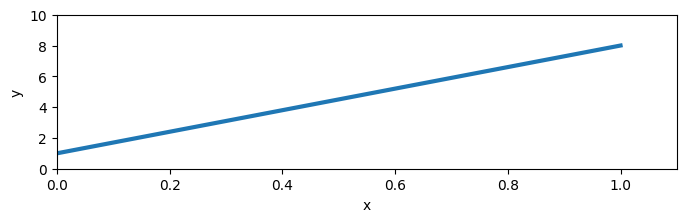

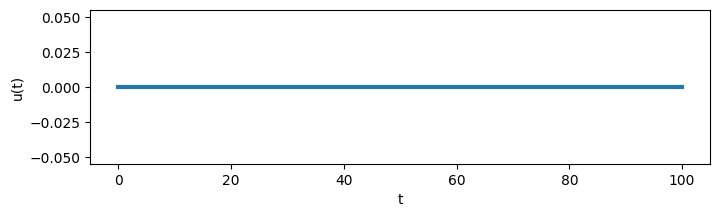

0.0 0.0 0.0


In [6]:
t0 = 0
tf = 100

U = 9
L = 7
sigma2 = 0.1**2
Sx = 0
Ex = 1

Sy = 1

C = (Ex - Sx) / (tf - t0)
g = 9.8

# determine how long to run the BVP solver
t_span = (0, 100)
t_steps = 100
t = np.linspace(t_span[0], t_span[1], t_steps)

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    x, y, xp, yp, p0, p1, p2, p3 = y_var
    u = p3
    zeros = np.zeros_like(x)
    ones = np.ones_like(x)
    return np.array([
        xp,         # x' = x'
        yp,         # y' = y'
        zeros,      # x'' = 0
        u - ones*g, # y'' = u - g
        zeros,      # p0' = -DH/Dx = 0
        zeros,      # p1' = -DH/Dy = 0
        -p0,        # p2' = -DH/Dx' = -p0
        -p1         # p3' = -DH/Dy' = -p1
    ])
    
def bc(ya, yb):
    y_tf = yb[1]
    avg_U_L = (U + L)/2
    
    p1_end = -1 * (-1/sigma2) * 2*(y_tf - avg_U_L) * np.exp(-(y_tf - avg_U_L)**2/sigma2)
    
    return np.array([
        ya[0] - Sx,         # x(0) = Sx
        ya[1] - Sy,         # y(0) = Sy
        ya[2] - C,          # x'(0) = C
        ya[3] - 0,          # y'(0) = 0
        yb[0] - Ex,         # x(tf) = Ex (1)
        yb[2] - C,          # x'(tf) = C
        yb[5] - p1_end,     # p1(tf) = -Dphi/Dy(tf)
        yb[7] - 0           # p3(tf) = -Dphi/Dy''(tf)
        
    ])

# solve the bvp with the y0
y0 = np.zeros((8, t_steps))

x_guess = np.linspace(Sx, Ex, t_steps)
y_guess = np.linspace(Sy, (U+L)/2, t_steps)
xp_guess = np.ones(t_steps)*C
yp_guess = np.ones(t_steps)*(((U+L)/2 - Sy) / (tf - t0))
p0_guess = np.zeros(t_steps)
p1_guess = np.zeros(t_steps)
p2_guess = np.zeros(t_steps)
p3_guess = np.ones(t_steps)*g
y0 = np.vstack((x_guess, y_guess, xp_guess, yp_guess, p0_guess, p1_guess, p2_guess, p3_guess))
sol = solve_bvp(ode, bc, t, y0, tol=1e-5, max_nodes=100_000)
print(sol.message)

# extract the values from the solution
x = sol.y[0]
y = sol.y[1]
xp = sol.y[2]
yp = sol.y[3]
p1 = sol.y[4]
p2 = sol.y[5]
p3 = sol.y[6]
p4 = sol.y[7]

# compute the optimal control
u = p3

# plot the x(t)
plt.plot(x, y, linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.gcf().set_size_inches(8,2)
plt.xlim(0,1.1)
plt.ylim(0,10)
plt.show()

# plot the u(t)
plt.plot(t, u, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.gcf().set_size_inches(8,2)
plt.show()

print(u[0], u[len(u)//2], u[-1])

# only y and y'

The algorithm converged to the desired accuracy.


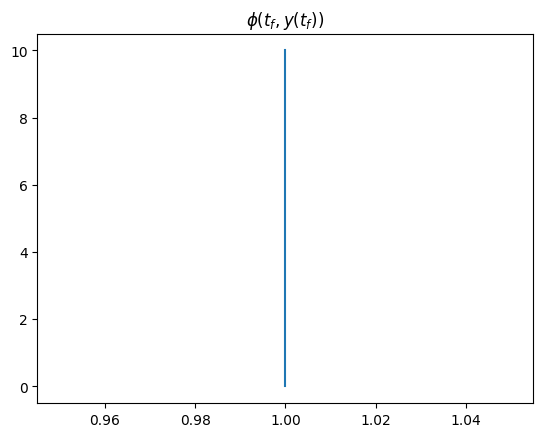

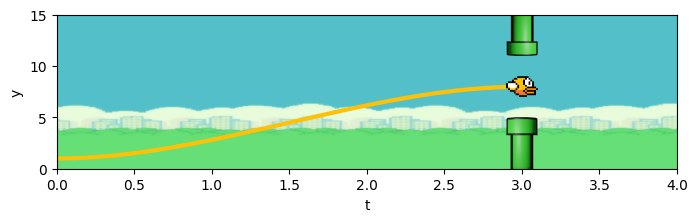

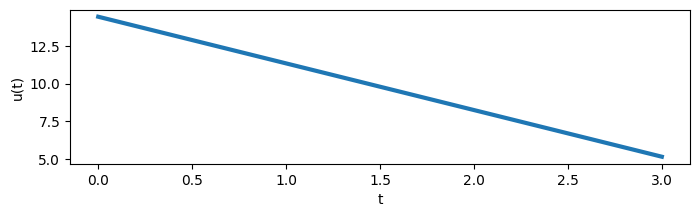

t: 0.0 1.5151515151515151 3.0
y: 1.0 4.544949750294442 7.984083650276033
u: 14.456055766850689 9.752969133668175 5.143944233149312


In [59]:
t0 = 0
tf = 3

U = 11
L = 5
sigma2 = 0.1**2

Sy = 1
g = 9.8

END_REWARD = 1

def phi(y_tf):
    return -1 * np.exp(-(y_tf - (L+U)/2)**2 / sigma2)

def phi_d(y_tf):
    return (2/sigma2) * (y_tf - (L+U)/2) * phi(y_tf)

# determine how long to run the BVP solver
t_span = (t0, tf)
t_steps = 100
t = np.linspace(t_span[0], t_span[1], t_steps)

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    y, yp, p0, p1 = y_var
    u = p1
    zeros = np.zeros_like(y)
    ones = np.ones_like(y)
    return np.array([
        yp,         # y' = y'
        u - ones*g, # y'' = u - g
        zeros,      # p0' = -DH/Dy = 0
        -p0         # p1' = -DH/Dy' = -p0
    ])
    
def bc(ya, yb):
    y_tf = yb[0]
    p0_end = END_REWARD * phi_d(y_tf)
    
    return np.array([
        ya[0] - Sy,         # y(0) = Sy
        ya[1] - 0,          # y'(0) = 0
        yb[1] - 0,          # y'(tf) = 0
        yb[2] - p0_end      # p0(tf) = p0_end
    ])

# solve the bvp with the y0
y0 = np.zeros((8, t_steps))

y_guess = np.linspace(Sy, (U+L)/2, t_steps)
yp_guess = np.ones(t_steps)*(((U+L)/2 - Sy) / (tf - t0))
p0_guess = np.zeros(t_steps)
p1_guess = np.ones(t_steps)
y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))
sol = solve_bvp(ode, bc, t, y0)#, tol=1e-5, max_nodes=100_000)
print(sol.message)

# extract the values from the solution
y = sol.y[0]
yp = sol.y[1]
p0 = sol.y[2]
p1 = sol.y[3]

# compute the optimal control
u = p1

# plot the reward
y_domain = np.linspace(0, 10, 100)
y_plot = phi(y_domain)
x_domain = np.ones_like(y_domain)
plt.plot(x_domain, y_domain)
plt.title("$\phi (t_f, y(t_f))$")
plt.show()

# plot the x(t)
plt.gcf().set_size_inches(8,2)

plt.plot(t, y, linewidth=3, color="#ffc107")
plt.xlabel("t")
plt.ylabel("y")

xlims = (0, 4)
ylims = (0, 15)
# plot the background
background = mpimg.imread('flappy_background.png')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)


# plot the upper pipe
xmin, xmax = 2.9, 3.1
ymin, ymax = U, 15
img = mpimg.imread('pipe_cropped_upper.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

xmin, xmax = 2.9, 3.1
ymin, ymax = 0, L
img = mpimg.imread('pipe_cropped_lower.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the bird
xmin, xmax = 2.9, 3.1
ymin, ymax = 7, 9
bird = mpimg.imread('bird_cropped.png')
plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)

plt.xlim(0, 4)
plt.ylim(0, 15)
plt.show()

# plot the u(t)
plt.plot(t, u, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.gcf().set_size_inches(8,2)
plt.show()

print("t:", t[0], t[len(t)//2], t[-1])
print("y:", y[0], y[len(y)//2], y[-1])
print("u:", u[0], u[len(u)//2], u[-1])

# super simple case

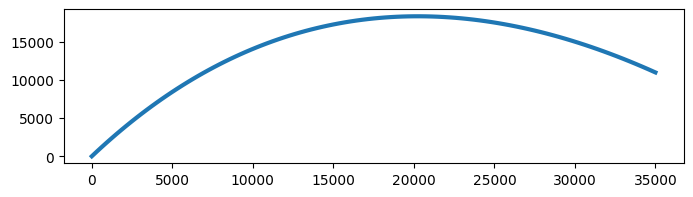

In [16]:
P_u = 9
P_l = 7
sigma2 = 1
Sx = 0
Sy = 0
forward_speed = 1
gravity = 9.8
Vx = 300
Vy = 600

# determine how long to run the BVP solver
t_span = (0, 100)
t_steps = 100
t, delta_t = np.linspace(t_span[0], t_span[1], t_steps, retstep=True)

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    x, y, xp, yp = y_var
    ones = np.ones_like(xp)
    return np.array([
        xp,         # x' = x + delta_T*x'
        yp,         # y' = y + delta_T*y'  
        ones,                     # x'' = x'
        -gravity*ones    # y'' = y' - g*delta_T
    ])
def bc(ya, yb):
    return np.array([
        ya[0] - Sx,             # x(0) = Sx
        ya[1] - Sy,             # y(0) = Sy
        ya[2] - Vx,  # x'(0) = forward_speed
        ya[3] - Vy               # y'(0) = 0
    ])

# solve the bvp with the y0
y0 = np.ones((4, t_steps))
sol = solve_bvp(ode, bc, t, y0)

# extract the values from the solution
x = sol.y[0]
y = sol.y[1]
xp = sol.y[2]
yp = sol.y[3]

# plot the x(t)
plt.plot(x, y, linewidth=3)
plt.gcf().set_size_inches(8,2)
plt.show()